# Non stationary Ornstein Uhlenbeck in 2D (Fokker-Planck Equation) with RAR sampling & SPINNs

We want to estimate the solution $u(t,\mathbf{x})$ of

$$
-\sum_{i=1}^2\frac{\partial}{\partial \mathbf{x}}
         \left[(\alpha(\mu - \mathbf{x}))u(t,\mathbf{x})\right] +
         \sum_{i=1}^2\sum_{j=1}^2\frac{\partial^2}{\partial x_i \partial x_j}              
         \left[\frac{\sigma^2}{2}u(t,\mathbf{x})\right]=                                   
         \frac{\partial}
         {\partial t}u(t,\mathbf{x})
 $$

The notebook is divided in two main sections:

1) Solving with PINNs and RAR

2) Solving with SPINNs

3) Conclusion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)


Create the DataGenerator object. In this notebook we illustrate an example using the Residual Adaptative Refinement algorithm for improved collocation points for PINN training. The reference is _DeepXDE: A deep learning library for solving differential equations_, L. Lu, SIAM Review, 2021.

Thus we first define an additional dictionary of parameters for the RAR algorithm, it will be passed at the initialization of the DataGenerator:

In [6]:
rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_rate':500, # nb of gradient steps between two RAR procedures
    'sample_size':500, # the size of the sample of collocation points from which the new collocation points will be taken
    'selected_sample_size':5, # the number of selected collocation points from the sample, to join the dataset.
}
n_start = 200 # the initial number of collocation points at beginning


Therefore, the set of parameters above gives the following number collocation points used (DataGenerator's `times` and `omega` attributes):
- 200 at iterations 0 to 1500
- 205 at iterations 1501 to 2000
- 210 at iterations 2001 to 2500
- ...

__Note:__ If given too many iterations, the RAR algorithm can require a number of collocation points that will be larger that `n`. In order to prevent an undefined behaviour, when such case is attained RAR updates will not happen anymore.

In [7]:
n = 500
nb = 4 # not used here
nt = 500
omega_batch_size = 32
omega_border_batch_size = None # not used here
temporal_batch_size = 20
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method="uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    2,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method=method,
    rar_parameters=rar_parameters,
    n_start=n_start
)


Initialize the PINN parameters and visualize the PINN output before training

In [8]:
init_nn_params = u.init_params()


In [9]:
vectorized_u_init = vmap(partial(u, u_params=init_nn_params), (0, 0), 0)


## Model parameters

In [10]:
# true solution N(0,1)
sigma = 0.5 * jnp.ones((2))
alpha = .5 * jnp.ones((2))
mu = jnp.zeros((2))

Tmax = 10


In our problem we know the analytical stationary solution

In [11]:
from jax.scipy.stats import multivariate_normal

def u_statio(x):
    return multivariate_normal.pdf(x, mean=mu, cov=jnp.diag((sigma/jnp.sqrt(2*alpha)) ** 2))

vectorized_u_statio = vmap(u_statio, (0), 0)


In [12]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
}


## Set up the initial condition

In [13]:
# Initial law at t=0
u0 = u_statio

# Another init
# TODO : implement other init
def u0(x):
    return multivariate_normal.pdf(x, mean=jnp.array([1, 1]), cov=0.1 * jnp.eye(2))

vectorized_u0 = vmap(u0, (0), 0)


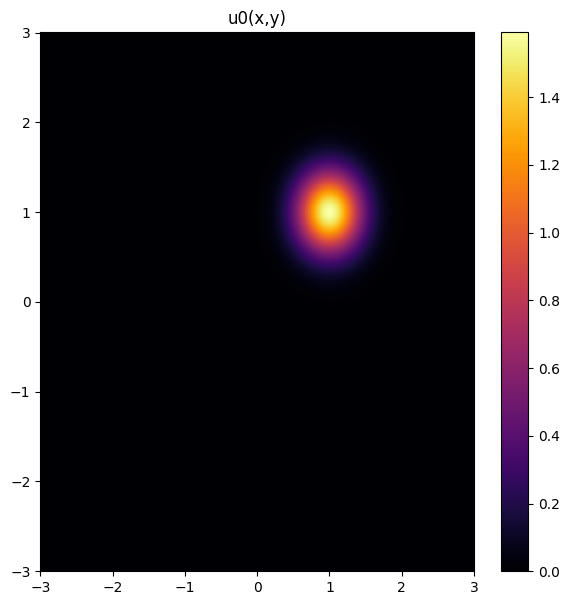

In [14]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)


## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [15]:
int_xmin, int_xmax = -5, 5
int_ymin, int_ymax = -5, 5

n_samples = int(1e3)
int_length = (int_xmax - int_xmin) * (int_ymax - int_ymin)
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(
            subkey1, shape = (1000, 1), minval=int_xmin, maxval=int_xmax
        ),
        random.uniform(
            subkey2, shape = (1000, 1), minval=int_ymin, maxval=int_ymax
        )
    ],
    axis=-1
)


In [16]:
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)


In [17]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax, "norm_loss":0.1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_borders=((int_xmin, int_xmax), (int_ymin, int_ymax)),
    norm_samples=mc_samples
)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:296: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [18]:
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


(640, 1)
total loss: 13250.65
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '133.95', 'initial_condition': '13.18', 'norm_loss': '13103.52', 'observations': '0.00', 'sobolev': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [19]:
params = init_params


In [20]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)


In [21]:
n_iter = int(50000)


In [22]:
params = init_params


We are performing RAR sampling scheme, let's see the distribution fo the collocation points before the start of the training.

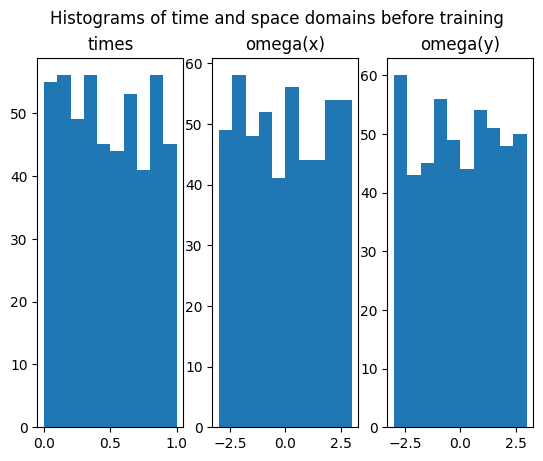

In [23]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.savefig("hist_data_before.pdf")
plt.show()


In [24]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)


(640, 1)
(640, 1)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:296: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


(640, 1)
(640, 1)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:296: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 0: loss value = 12847.962890625
Iteration 1000: loss value = 1.7916841506958008
Iteration 2000: loss value = 0.1740192025899887
Iteration 3000: loss value = 0.03510773554444313
Iteration 4000: loss value = 0.03477783128619194
Iteration 5000: loss value = 0.18727357685565948
Iteration 6000: loss value = 0.019927198067307472
Iteration 7000: loss value = 0.04043903201818466
Iteration 8000: loss value = 0.4743790030479431
Iteration 9000: loss value = 0.014533860608935356
Iteration 10000: loss value = 0.064847931265831
Iteration 11000: loss value = 0.01980147883296013
Iteration 12000: loss value = 0.7215108871459961
Iteration 13000: loss value = 0.182850643992424
Iteration 14000: loss value = 0.18288391828536987
Iteration 15000: loss value = 1.1862746477127075
Iteration 16000: loss value = 0.11794156581163406
Iteration 17000: loss value = 0.18990886211395264
Iteration 18000: loss value = 0.054421018809080124
Iteration 19000: loss value = 0.001428814954124391
Iteration 20000: loss 

In the next figure, we see the distribution fo the collocation points after the end of the training. We see that the new points are preferentially added at $t=0$, on the borders and around the origin in the upper right quadrant. This could be expected since we expected that those are the collocation points where most things actually happen.

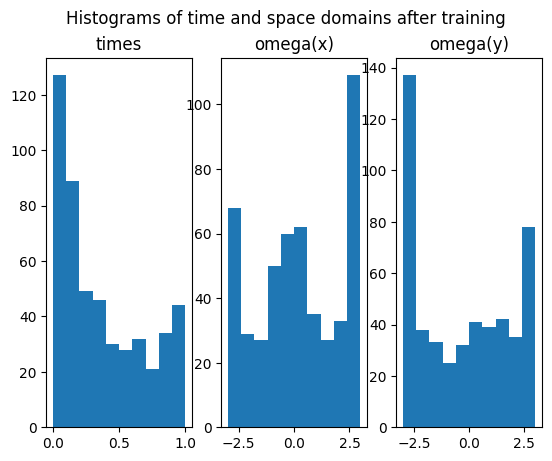

In [25]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.savefig("hist_data_after.pdf")
plt.show()


## Results

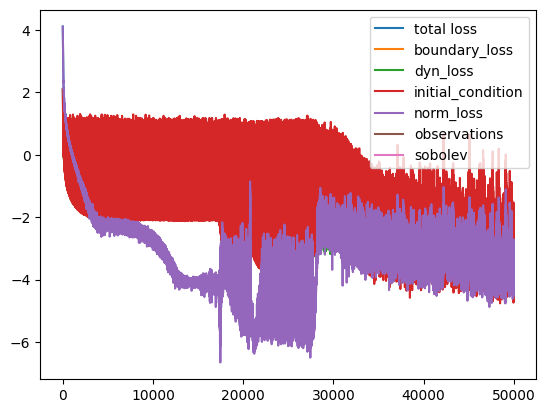

In [26]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.legend()
plt.show();


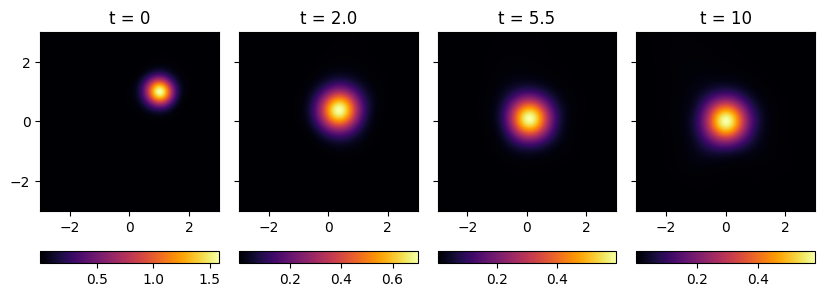

In [27]:
times = [0, 0.2, 0.55, 1] # times in the rescaled time susescale
u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


__Conclusion on RAR sampling:__ We can see that given 20000 iterations and the RAR sampling scheme defined above we ended up with a better result than with a standard and fixed uniform sampling of collocation points. Indeed, we performed the experiment and obtained the following final figure, where intensities and shape are not well determined:

![fig](2d_nonstatio_ou_standardsampling.png)

Therefore, given the same number of iterations and a total number of collocation points equal to the final number of collocation points at the end of RAR sampling, we here see the advantage of RAR sampling. This figure can be reproduced by simply setting `rar_parameters=None` at the data generator creation at the beginning of the notebook. Note that the standard and fixed uniform sampling of collocation points can also give good results in this experiment by setting a bigger number of iterations or bigger number of collocation points.

## 2) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

In [59]:
d = 3
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)

In [60]:
u = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")
init_nn_params = u.init_params()

In [69]:
n = 500
nb = 4 # not used here
nt = 500
omega_batch_size = 32
omega_border_batch_size = None # not used here
temporal_batch_size = 32
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method="uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    2,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method=method
)

In [70]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
}

In [71]:
int_xmin, int_xmax = -5, 5
int_ymin, int_ymax = -5, 5

n_samples = 32
int_length = (int_xmax - int_xmin) * (int_ymax - int_ymin)
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(
            subkey1, shape = (n_samples, 1), minval=int_xmin, maxval=int_xmax
        ),
        random.uniform(
            subkey2, shape = (n_samples, 1), minval=int_ymin, maxval=int_ymax
        )
    ],
    axis=-1
)

In [72]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax, "norm_loss":0.1 * Tmax}
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_borders=((int_xmin, int_xmax), (int_ymin, int_ymax)),
    norm_samples=mc_samples
)


In [73]:
params = init_params

In [74]:
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = int(20000)
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 0: loss value = 71.84600830078125
Iteration 1000: loss value = 0.18581371009349823
Iteration 2000: loss value = 0.058515213429927826
Iteration 3000: loss value = 0.018428856506943703
Iteration 4000: loss value = 0.0193961001932621
Iteration 5000: loss value = 0.028021659702062607
Iteration 6000: loss value = 0.005443263798952103
Iteration 7000: loss value = 0.009827300906181335
Iteration 8000: loss value = 0.009956061840057373
Iteration 9000: loss value = 0.00816250964999199
Iteration 10000: loss value = 0.3403272032737732
Iteration 11000: loss value = 0.23326091468334198
Iteration 12000: loss value = 0.13378611207008362
Iteration 13000: loss value = 0.06580539047718048
Iteration 14000: loss value = 0.14776454865932465
Iteration 15000: loss value = 0.04802947863936424
Iteration 16000: loss value = 0.059978973120450974
Iteration 17000: loss value = 0.02333122119307518
Iteration 18000: loss value = 0.008791651576757431
Iteration 19000: loss value = 0.023443160578608513
Iteratio

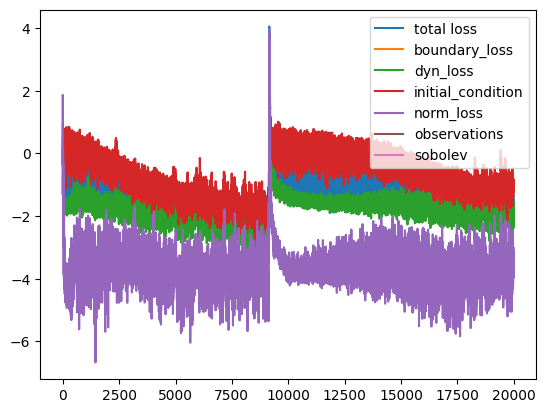

In [75]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.legend()
plt.show();


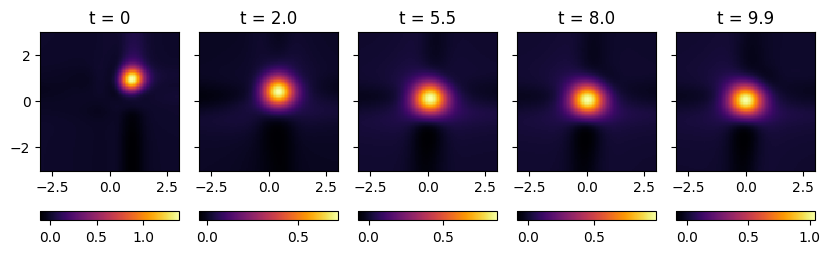

In [76]:
nx, ny = 100, 100 # Set less validation points for SPINN otherwise GPU memory explodes
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]


times = [0, 0.2, 0.55, 0.8, 0.99] # times in the rescaled time susescale
u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times)),
    spinn=True
)


## 3) Conclusion

We solved this 2D non-stationary Fokker-Planck PDE using both PINNs and SPINNs. SPINNs and PINNs end up with more or less the same estimation. A slight speed advantage goes to SPINN but the PINN approach really benefits from RAR sampling to obtain a more accurate estimation in fine. Note that the SPINN setting could probably be fine-tuned. Respective times are:

- For the PINN: 50000/50000 [03:05<00:00, 268.93it/s]

- For the SPINN:  15000/15000 [02:16<00:00, 102.78it/s]

(Times obtained on GPU Nvidia T600).

In the near future, RAR sampling will be considered as a feature for SPINNs in `jinns`.

TODO: finetune SPINN in this example